Training Variational Autoencoders on FashionMNIST
Device: cuda
Batch size: 128
Latent dimension: 20
Epochs: 50
Learning rate: 0.001

[1/5] Loading FashionMNIST dataset...


100%|██████████| 26.4M/26.4M [00:02<00:00, 13.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.4MB/s]


Train size: 48000, Val size: 12000, Test size: 10000

[2/5] Training standard VAE...
Epoch 1/50: Train Loss: 41.5961 (Recon: 34.9255, KL: 6.6706), Val Loss: 32.1997 (Recon: 24.6891, KL: 7.5106)
Epoch 2/50: Train Loss: 30.0306 (Recon: 22.5747, KL: 7.4559), Val Loss: 28.7519 (Recon: 20.9099, KL: 7.8420)
Epoch 3/50: Train Loss: 28.0249 (Recon: 20.4550, KL: 7.5699), Val Loss: 27.3710 (Recon: 19.7630, KL: 7.6081)
Epoch 4/50: Train Loss: 27.0675 (Recon: 19.3386, KL: 7.7289), Val Loss: 26.7642 (Recon: 18.9631, KL: 7.8011)
Epoch 5/50: Train Loss: 26.5453 (Recon: 18.7194, KL: 7.8260), Val Loss: 26.4784 (Recon: 18.7040, KL: 7.7744)
Epoch 6/50: Train Loss: 26.1898 (Recon: 18.3119, KL: 7.8779), Val Loss: 26.1833 (Recon: 18.4641, KL: 7.7192)
Epoch 7/50: Train Loss: 25.8980 (Recon: 17.9816, KL: 7.9164), Val Loss: 25.8398 (Recon: 17.8726, KL: 7.9672)
Epoch 8/50: Train Loss: 25.6860 (Recon: 17.7344, KL: 7.9516), Val Loss: 25.5970 (Recon: 17.4349, KL: 8.1621)
Epoch 9/50: Train Loss: 25.4578 (Recon: 17.

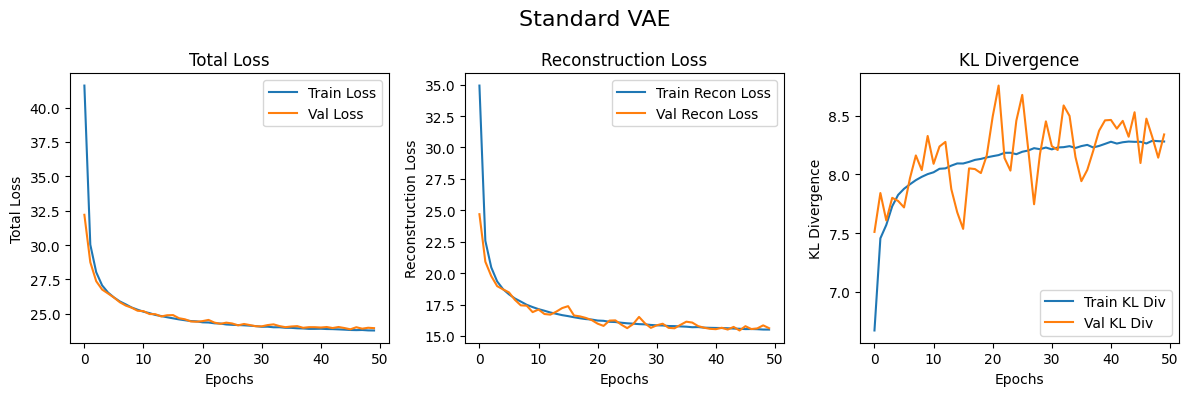


[3/5] Training Beta-VAE with warmup...
Epoch 1/50: Beta: 0.00, Train Loss: 25.0209 (Recon: 25.0209, KL: 145.8606), Val Loss: 14.2473 (Recon: 14.2473, KL: 220.0507)
Epoch 2/50: Beta: 0.10, Train Loss: 18.5637 (Recon: 14.7325, KL: 38.3119), Val Loss: 16.6308 (Recon: 13.2538, KL: 33.7698)
Epoch 3/50: Beta: 0.20, Train Loss: 18.9684 (Recon: 13.8089, KL: 25.7973), Val Loss: 18.3570 (Recon: 13.3337, KL: 25.1164)
Epoch 4/50: Beta: 0.30, Train Loss: 20.3057 (Recon: 13.8790, KL: 21.4222), Val Loss: 20.0689 (Recon: 13.5857, KL: 21.6109)
Epoch 5/50: Beta: 0.40, Train Loss: 21.6297 (Recon: 14.2962, KL: 18.3337), Val Loss: 21.4063 (Recon: 14.2885, KL: 17.7946)
Epoch 6/50: Beta: 0.50, Train Loss: 22.7949 (Recon: 14.8348, KL: 15.9202), Val Loss: 22.5726 (Recon: 15.0422, KL: 15.0608)
Epoch 7/50: Beta: 0.60, Train Loss: 23.7489 (Recon: 15.3721, KL: 13.9613), Val Loss: 23.4810 (Recon: 15.0990, KL: 13.9699)
Epoch 8/50: Beta: 0.70, Train Loss: 24.5327 (Recon: 15.8637, KL: 12.3843), Val Loss: 24.3467 (Rec

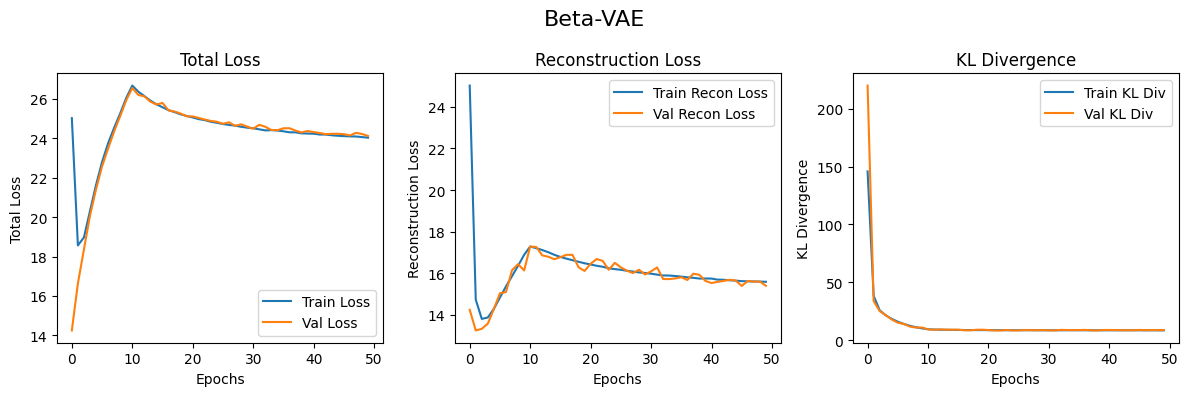


[4/5] Generating visualizations...
  - Reconstructions...


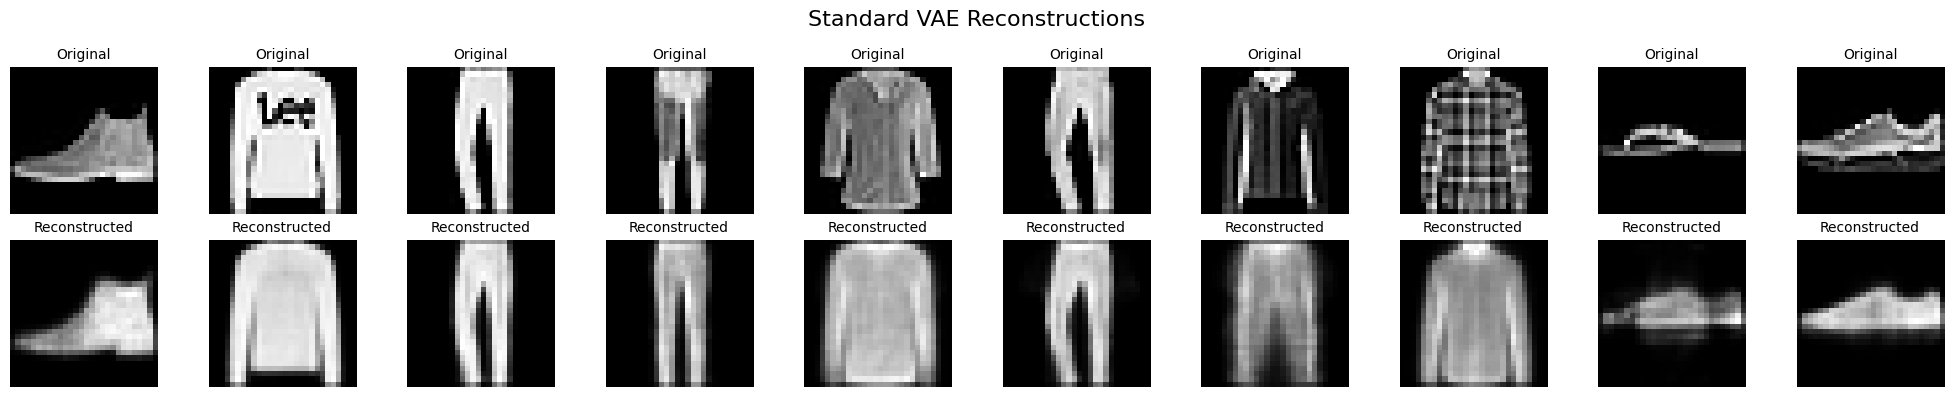

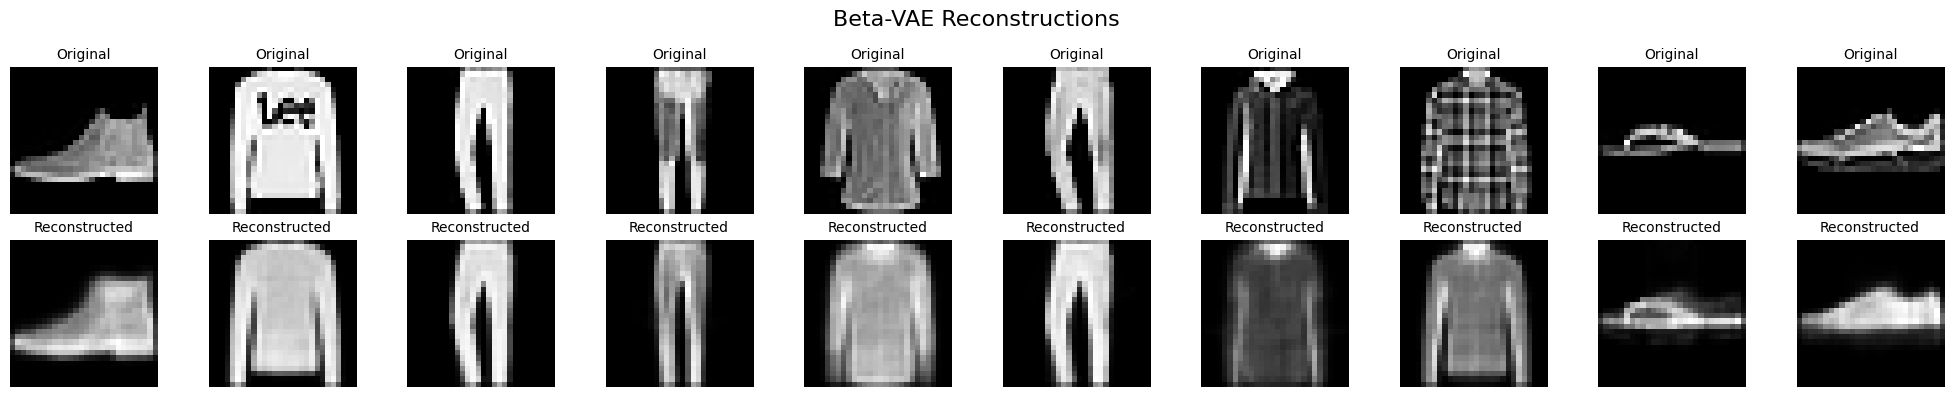

  - Gaussian generations...


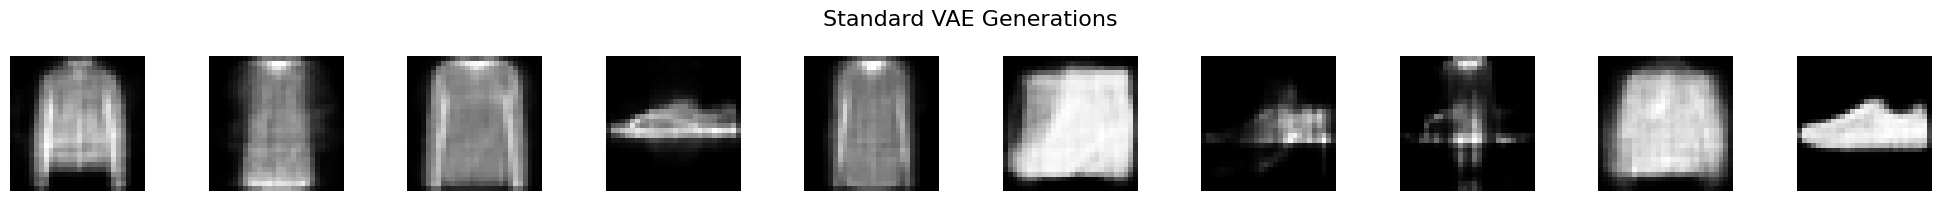

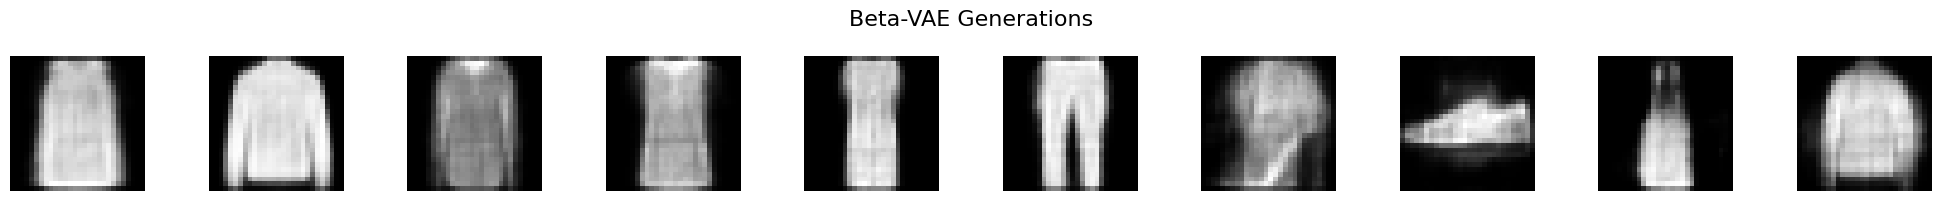

  - Laplacian generations...


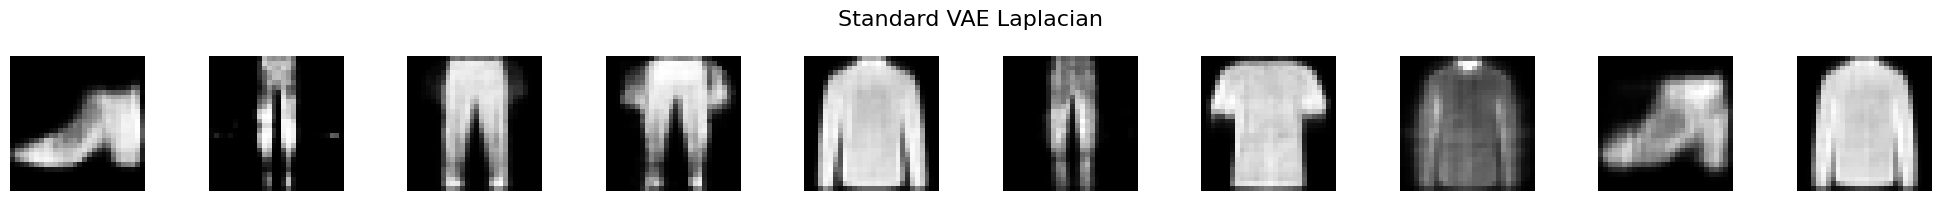

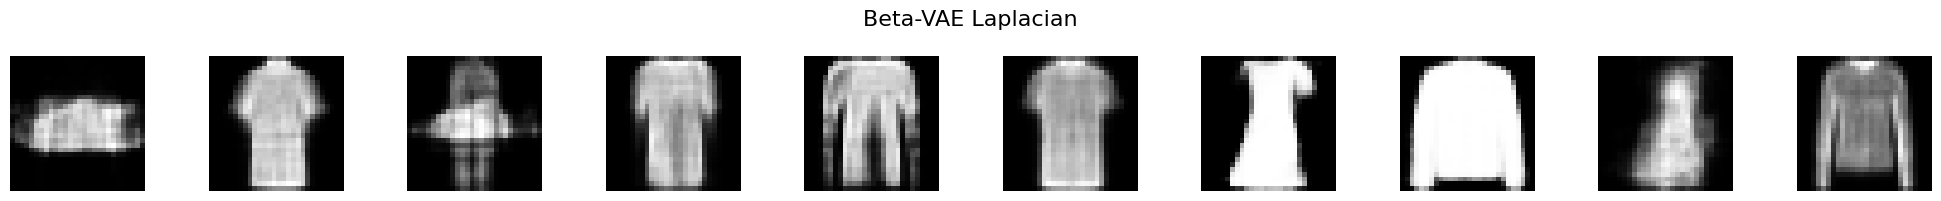


[5/5] Posterior collapse analysis...

Test Set ELBO Components:
Standard VAE - Test Recon: 15.6856, KL: 8.2926
Beta-VAE     - Test Recon: 15.4788, KL: 8.6703

Posterior Statistics:
Standard VAE - Mu Mean: 0.0060, Mu Var: 0.2899, Std Mean: 0.7112
Beta-VAE - Mu Mean: -0.0107, Mu Var: 0.3132, Std Mean: 0.6894

Saving models...
Models saved as 'vae_standard.pth' and 'vae_beta.pth'

Training complete!


In [1]:
"""
Variational Autoencoder (VAE) Training Script
This script trains VAEs on FashionMNIST with standard and beta-VAE variants.
Includes visualization, posterior collapse analysis, and generation from different priors.
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# ============================================================================
# Configuration
# ============================================================================

class Config:
    """Configuration parameters for VAE training"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 128
    latent_dim = 20
    hidden_dim = 400
    input_dim = 784
    epochs = 50
    lr = 1e-3
    warmup_epochs = 10  # For beta-VAE warmup
    train_split = 0.8


# ============================================================================
# Data Loading
# ============================================================================

def load_fashion_mnist(batch_size, train_split=0.8):
    """Load and prepare FashionMNIST dataset with train/val/test splits"""
    transform = transforms.Compose([transforms.ToTensor()])

    # Download datasets
    train_dataset_full = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform
    )

    # Split train into train/val
    train_size = int(train_split * len(train_dataset_full))
    val_size = len(train_dataset_full) - train_size
    train_dataset, val_dataset = random_split(
        train_dataset_full, [train_size, val_size]
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Train size: {len(train_dataset)}, "
          f"Val size: {len(val_dataset)}, "
          f"Test size: {len(test_dataset)}")

    return train_loader, val_loader, test_loader


# ============================================================================
# Model Definition
# ============================================================================

class VAE(nn.Module):
    """Variational Autoencoder with Gaussian encoder and decoder"""

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        """Encode input to latent distribution parameters"""
        h = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick for sampling"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decode latent sample to reconstruction"""
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        """Forward pass through encoder, reparameterize, and decoder"""
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


# ============================================================================
# Loss Functions
# ============================================================================

def vae_loss(recon_x, x, mu, logvar):
    """Standard VAE loss: reconstruction + KL divergence"""
    recon_loss = nn.functional.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div, recon_loss, kl_div


def vae_loss_beta(recon_x, x, mu, logvar, beta):
    """Beta-VAE loss with adjustable KL weight"""
    recon_loss = nn.functional.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div, recon_loss, kl_div


# ============================================================================
# Training Functions
# ============================================================================

def train_epoch(model, loader, optimizer, loss_fn, beta=1.0, device='cpu'):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for batch in loader:
        x, _ = batch
        x = x.to(device)

        recon_x, mu, logvar = model(x)
        loss, recon_loss, kl_div = loss_fn(recon_x, x, mu, logvar, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_div.item()

    n_samples = len(loader.dataset)
    return total_loss / n_samples, total_recon / n_samples, total_kl / n_samples


def validate_epoch(model, loader, loss_fn, beta=1.0, device='cpu'):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    with torch.no_grad():
        for batch in loader:
            x, _ = batch
            x = x.to(device)

            recon_x, mu, logvar = model(x)
            loss, recon_loss, kl_div = loss_fn(recon_x, x, mu, logvar, beta)

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_div.item()

    n_samples = len(loader.dataset)
    return total_loss / n_samples, total_recon / n_samples, total_kl / n_samples


def train_vae(model, train_loader, val_loader, epochs, lr, device,
              use_beta=False, warmup_epochs=10):
    """Complete training loop for VAE"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = vae_loss_beta if use_beta else lambda r, x, m, lv, b: vae_loss(r, x, m, lv)

    history = {
        'train_loss': [], 'train_recon': [], 'train_kl': [],
        'val_loss': [], 'val_recon': [], 'val_kl': []
    }

    for epoch in range(epochs):
        # Beta warmup for beta-VAE
        if use_beta:
            beta = min(1.0, epoch / warmup_epochs) if epoch < warmup_epochs else 1.0
        else:
            beta = 1.0

        # Train and validate
        train_loss, train_recon, train_kl = train_epoch(
            model, train_loader, optimizer, loss_fn, beta, device
        )
        val_loss, val_recon, val_kl = validate_epoch(
            model, val_loader, loss_fn, beta, device
        )

        # Record history
        history['train_loss'].append(train_loss)
        history['train_recon'].append(train_recon)
        history['train_kl'].append(train_kl)
        history['val_loss'].append(val_loss)
        history['val_recon'].append(val_recon)
        history['val_kl'].append(val_kl)

        # Print progress
        if use_beta:
            print(f'Epoch {epoch+1}/{epochs}: Beta: {beta:.2f}, '
                  f'Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f}), '
                  f'Val Loss: {val_loss:.4f} (Recon: {val_recon:.4f}, KL: {val_kl:.4f})')
        else:
            print(f'Epoch {epoch+1}/{epochs}: '
                  f'Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f}), '
                  f'Val Loss: {val_loss:.4f} (Recon: {val_recon:.4f}, KL: {val_kl:.4f})')

    return history


# ============================================================================
# Visualization Functions
# ============================================================================

def plot_training_history(history, title=""):
    """Plot training curves"""
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Total loss
    axs[0].plot(history['train_loss'], label='Train Loss')
    axs[0].plot(history['val_loss'], label='Val Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Total Loss')
    axs[0].legend()
    axs[0].set_title('Total Loss')

    # Reconstruction loss
    axs[1].plot(history['train_recon'], label='Train Recon Loss')
    axs[1].plot(history['val_recon'], label='Val Recon Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Reconstruction Loss')
    axs[1].legend()
    axs[1].set_title('Reconstruction Loss')

    # KL divergence
    axs[2].plot(history['train_kl'], label='Train KL Div')
    axs[2].plot(history['val_kl'], label='Val KL Div')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('KL Divergence')
    axs[2].legend()
    axs[2].set_title('KL Divergence')

    if title:
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.savefig(f'training_history_{title.replace(" ", "_").lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_reconstructions(model, loader, n=10, title="", device='cpu'):
    """Visualize original images and their reconstructions"""
    model.eval()

    with torch.no_grad():
        batch = next(iter(loader))[0][:n].to(device)
        recon, _, _ = model(batch)
        recon = recon.view(-1, 1, 28, 28).cpu()
        original = batch.cpu()

    fig, axs = plt.subplots(2, n, figsize=(n*2, 4))
    if title:
        fig.suptitle(title, fontsize=16)

    for i in range(n):
        axs[0, i].imshow(original[i].squeeze(), cmap='gray')
        axs[0, i].set_title("Original", fontsize=10)
        axs[0, i].axis('off')

        axs[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axs[1, i].set_title("Reconstructed", fontsize=10)
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.savefig(f'reconstructions_{title.replace(" ", "_").lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_generations(model, latent_dim, n=10, title="", device='cpu'):
    """Generate new samples from Gaussian prior"""
    model.eval()

    with torch.no_grad():
        z = torch.randn(n, latent_dim).to(device)
        samples = model.decode(z).view(-1, 1, 28, 28).cpu()

    fig, axs = plt.subplots(1, n, figsize=(n*2, 2))
    if title:
        fig.suptitle(title, fontsize=16)

    for i in range(n):
        axs[i].imshow(samples[i].squeeze(), cmap='gray')
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig(f'generations_gaussian_{title.replace(" ", "_").lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()


def sample_laplacian(n, dim):
    """Sample from Laplacian distribution"""
    u = torch.rand(n, dim) - 0.5
    return -torch.sign(u) * torch.log(1 - 2 * torch.abs(u))


def visualize_laplacian_generations(model, latent_dim, n=10, title="", device='cpu'):
    """Generate new samples from Laplacian prior"""
    model.eval()

    with torch.no_grad():
        z = sample_laplacian(n, latent_dim).to(device)
        samples = model.decode(z).view(-1, 1, 28, 28).cpu()

    fig, axs = plt.subplots(1, n, figsize=(n*2, 2))
    if title:
        fig.suptitle(title, fontsize=16)

    for i in range(n):
        axs[i].imshow(samples[i].squeeze(), cmap='gray')
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig(f'generations_laplacian_{title.replace(" ", "_").lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()


# ============================================================================
# Analysis Functions
# ============================================================================

def check_posterior_collapse(model, loader, model_name="", device='cpu'):
    """Check for posterior collapse by analyzing latent statistics"""
    model.eval()
    mus, logvars = [], []

    with torch.no_grad():
        for batch in loader:
            x, _ = batch
            x = x.to(device)
            mu, logvar = model.encode(x.view(-1, 784))
            mus.append(mu.cpu())
            logvars.append(logvar.cpu())

    mus = torch.cat(mus)
    logvars = torch.cat(logvars)

    mu_mean = mus.mean().item()
    mu_var = mus.var().item()
    std_mean = torch.exp(logvars).mean().item()

    print(f'{model_name} - Mu Mean: {mu_mean:.4f}, '
          f'Mu Var: {mu_var:.4f}, '
          f'Std Mean: {std_mean:.4f}')

    return mu_mean, mu_var, std_mean


def evaluate_elbo_components(model, loader, beta=1.0, device='cpu'):
    """Evaluate ELBO components on a dataset"""
    model.eval()
    recon_total = 0
    kl_total = 0
    n_samples = 0

    with torch.no_grad():
        for batch in loader:
            x, _ = batch
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            _, recon_loss, kl_div = vae_loss_beta(recon_x, x, mu, logvar, beta)
            recon_total += recon_loss.item()
            kl_total += kl_div.item()
            n_samples += x.size(0)

    return recon_total / n_samples, kl_total / n_samples


# ============================================================================
# Main Execution
# ============================================================================

def main():
    """Main training and evaluation pipeline"""
    config = Config()

    print("=" * 70)
    print("Training Variational Autoencoders on FashionMNIST")
    print("=" * 70)
    print(f"Device: {config.device}")
    print(f"Batch size: {config.batch_size}")
    print(f"Latent dimension: {config.latent_dim}")
    print(f"Epochs: {config.epochs}")
    print(f"Learning rate: {config.lr}")
    print("=" * 70)

    # Load data
    print("\n[1/5] Loading FashionMNIST dataset...")
    train_loader, val_loader, test_loader = load_fashion_mnist(
        config.batch_size, config.train_split
    )

    # Train standard VAE
    print("\n[2/5] Training standard VAE...")
    model = VAE(config.input_dim, config.hidden_dim, config.latent_dim).to(config.device)
    history = train_vae(
        model, train_loader, val_loader, config.epochs, config.lr,
        config.device, use_beta=False
    )
    plot_training_history(history, "Standard VAE")

    # Train Beta-VAE
    print("\n[3/5] Training Beta-VAE with warmup...")
    model_beta = VAE(config.input_dim, config.hidden_dim, config.latent_dim).to(config.device)
    history_beta = train_vae(
        model_beta, train_loader, val_loader, config.epochs, config.lr,
        config.device, use_beta=True, warmup_epochs=config.warmup_epochs
    )
    plot_training_history(history_beta, "Beta-VAE")

    # Visualizations
    print("\n[4/5] Generating visualizations...")

    print("  - Reconstructions...")
    visualize_reconstructions(model, test_loader, n=10,
                            title="Standard VAE Reconstructions",
                            device=config.device)
    visualize_reconstructions(model_beta, test_loader, n=10,
                            title="Beta-VAE Reconstructions",
                            device=config.device)

    print("  - Gaussian generations...")
    visualize_generations(model, config.latent_dim, n=10,
                         title="Standard VAE Generations",
                         device=config.device)
    visualize_generations(model_beta, config.latent_dim, n=10,
                         title="Beta-VAE Generations",
                         device=config.device)

    print("  - Laplacian generations...")
    visualize_laplacian_generations(model, config.latent_dim, n=10,
                                   title="Standard VAE Laplacian",
                                   device=config.device)
    visualize_laplacian_generations(model_beta, config.latent_dim, n=10,
                                   title="Beta-VAE Laplacian",
                                   device=config.device)

    # Analysis
    print("\n[5/5] Posterior collapse analysis...")
    print("\nTest Set ELBO Components:")
    recon_orig, kl_orig = evaluate_elbo_components(model, test_loader, device=config.device)
    recon_beta, kl_beta = evaluate_elbo_components(model_beta, test_loader, device=config.device)
    print(f"Standard VAE - Test Recon: {recon_orig:.4f}, KL: {kl_orig:.4f}")
    print(f"Beta-VAE     - Test Recon: {recon_beta:.4f}, KL: {kl_beta:.4f}")

    print("\nPosterior Statistics:")
    check_posterior_collapse(model, test_loader, "Standard VAE", config.device)
    check_posterior_collapse(model_beta, test_loader, "Beta-VAE", config.device)

    # Save models
    print("\nSaving models...")
    torch.save(model.state_dict(), 'vae_standard.pth')
    torch.save(model_beta.state_dict(), 'vae_beta.pth')
    print("Models saved as 'vae_standard.pth' and 'vae_beta.pth'")

    print("\n" + "=" * 70)
    print("Training complete!")
    print("=" * 70)


if __name__ == "__main__":
    main()